#**Deep Learning Homework 3: Convolutional Neural Networks**
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. We will use the CIFAR-10 dataset. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters on the learning performances.

# Requirements
Let's start importing the libraries we will need and setting a couple of environmental variables.

**Disclaimer**: the notebook has been tested in Colab with Python `3.9.16`. Some parts *may* not work as expected using different packages and Python versions.

In [ ]:
print("You are using:")
!python --version

You are using:
Python 3.9.16


In [ ]:
# They've just released torch 2.0, but we will use the more stable torch=1.13 along with other supporting libriaries
!pip3 install pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling 

In [ ]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from torchinfo import summary
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") # conflict of nn.functional.act_f and torch.act_f

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 525.85.12, 15360 MiB, 3 MiB, 15098 MiB


# Exercise 3.1: Simple CNN

## Data Loading and Preprocessing [TO COMPLETE]


We will use the `CIFAR-10` dataset.The dataset consists of $60.000$ images in $10$ classes, with $6.000$ images per class. There are $50.000$ training images and $10.000$ test images. Each sample is a $32\times32$ pixels color image (thus with an extra $\times3$ dimensions for the colors channels), associated with a label from one of the classes:

```python
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
```

We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.

**[TO COMPLETE]**

In the standard dataset, each pixel intensity is represented by a `uint8` (byte) from $0$ to $255$. As a preprocessing step, we will rescale these values in the range $[0,1]$. You should write a simple so-called MinMaxScaler which takes as input a PIL Image (a specific format for images in Python) and rescales it, after making the appropriate type and shape transformations.

`%STARTCODE`

In [ ]:
################################
### [TO COMPLETE] START ###
def MinMaxScaler(img):
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  # TO COMPLETE: transform the array to Tensor for PyTorch
  img_as_tensor = torch.from_numpy(img_as_array)
  # TO COMPLETE: image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  img_as_tensor = img_as_tensor.permute(2, 0, 1)
  # TO COMPLETE: rescale image pixels form [0, 255] to [0, 1]
  normalized_img = img_as_tensor / 255.0
  return normalized_img
### [TO COMPLETE] END ###
################################

'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(MinMaxScaler)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(MinMaxScaler)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


`%ENDCODE`

In [ ]:
# Let's check the classes and dataset shapes:
classes = dataset.classes
print(f"{classes=}")
print(f"Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {test_data.data.shape}")

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [ ]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Lambda()

In [ ]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

We split the dataset into training/validation sets:

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 45000 
Validation samples = 5000 
Test samples = 10000


Let's see how normalized sample looks like...

In [ ]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.7373, 0.7216, 0.7255,  ..., 0.7922, 0.7922, 0.7882],
         [0.7216, 0.7059, 0.7137,  ..., 0.7765, 0.7725, 0.7725],
         [0.7373, 0.7255, 0.7216,  ..., 0.7569, 0.7529, 0.7490],
         ...,
         [0.7608, 0.7608, 0.7647,  ..., 0.7647, 0.7765, 0.7686],
         [0.8039, 0.8000, 0.8039,  ..., 0.8157, 0.8157, 0.8000],
         [0.8235, 0.8157, 0.8157,  ..., 0.7922, 0.8000, 0.7804]],

        [[0.6902, 0.6784, 0.6824,  ..., 0.7490, 0.7490, 0.7451],
         [0.6784, 0.6627, 0.6706,  ..., 0.7333, 0.7294, 0.7294],
         [0.6941, 0.6824, 0.6784,  ..., 0.7137, 0.7098, 0.7059],
         ...,
         [0.7137, 0.7098, 0.7137,  ..., 0.7137, 0.7255, 0.7176],
         [0.7569, 0.7569, 0.7608,  ..., 0.7725, 0.7725, 0.7569],
         [0.7804, 0.7725, 0.7725,  ..., 0.7490, 0.7569, 0.7373]],

        [[0.6745, 0.6627, 0.6667,  ..., 0.7333, 0.7333, 0.7294],
         [0.6588, 0.6471, 0.6549,  ..., 0.7176, 0.7137, 0.7137],
         [0.6784, 0.6667, 0.6627,  ..., 0.6980, 0.6941, 0

... it's better to see it as images!

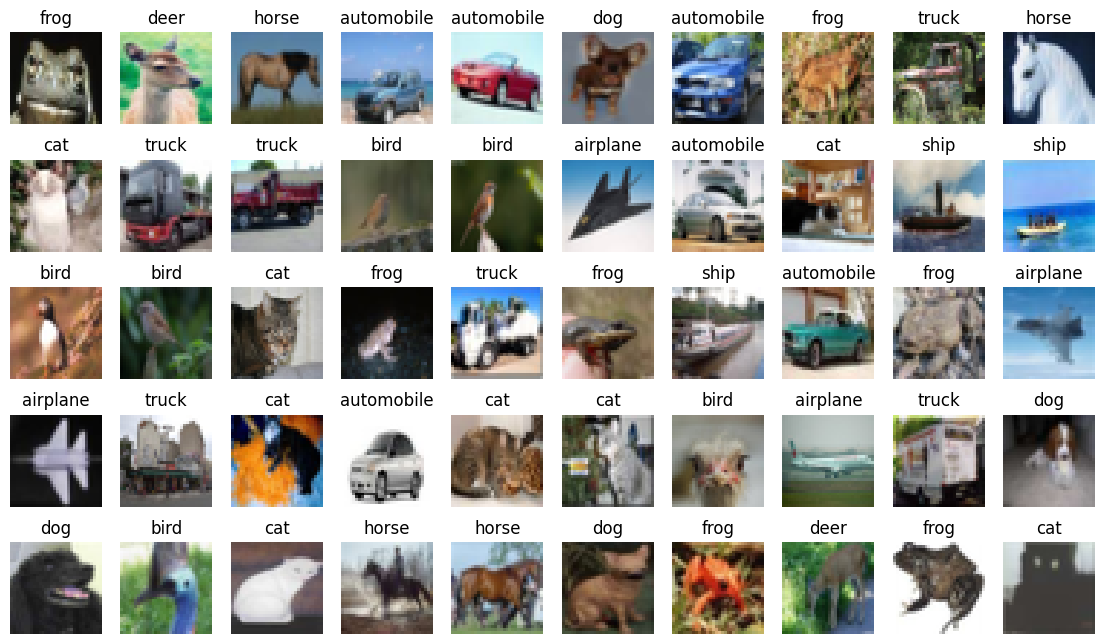

In [ ]:
img_chan, img_height, img_width = train_data[idx][0].shape # channel, height, width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) # C, H, W --> H, W, C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Explain in the cell below when using Gradient Descent, why it is usually a good idea to ensure that all the features have a similar scale.

`%STARTEXT`

**Answer**:

When using gradient descent as an optimization algorithm for training deep learning models, it is generally a good idea to ensure that all the features have a similar scale. This is because gradient descent relies on updating model parameters based on the magnitude of the gradients of the loss function with respect to the model parameters. If the features have different scales, the gradients for different features may also have different magnitudes, which can lead to imbalanced updates and slow convergence during training.

Here are a few reasons why it is important to have features with similar scales when using gradient descent:

1. Balanced updates: GD updates the model parameters by taking steps proportional to the magnitude of the gradients. If the features have different scales, the gradients for features with larger scales will also be larger, leading to larger updates for those features compared to features with smaller scales. This can result in imbalanced updates and cause the model to converge slowly or even fail to converge at all;

2. Faster convergence: having features with similar scales allows the model to converge faster during training. When the features are on a similar scale, the gradients are also on a similar scale, and the updates to the model parameters are more balanced. This can help the model to converge to the optimal solution more quickly;

3. Stable optimization: GD can be sensitive to the scale of the features, and having features with vastly different scales can result in numerical instability during optimization. Large gradients from features with large scales can cause issues such as exploding gradients, where the gradients become too large and cause the optimization process to diverge or fail to converge;

4. Interpretability: having features with similar scales makes it easier to interpret the importance and contributions of different features to the model's predictions. When features have different scales, it becomes challenging to compare their relative importance, and the interpretation of the model becomes more complex.

`%ENDTEXT`

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [ ]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

##Model Definition and Training

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLU activation function
* a Max Pooling layer (2D) of size 2x2.
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class). We do not need to normalize or transform further the outputs, as the `CrossEntropyLoss` takes care of that. Another equivalent approach would be to add a `LogSoftmax` final layer that returns log-probabilities and then use the `NegativeLogLikelihoodLoss`., and with the _softmax_ activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as `input_shape` attribute's value in the first layer report also the third dimension that represents the channel.

In [ ]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # Max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes) # 10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        # Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))

      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))

    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) # if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) # no need to use softmax because of the loss function

In [ ]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

Note that the number of parameters mostly depends on the output layers, indeed the parameter sharing techinique used by the 2D convolutional layers allows to significantly reduce the number of learnable weights.
Now we can train the model.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train / n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train / total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val / n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val / total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 40.41%, Loss: 1.70188892 ---------------- Val_Acc: 48.24%, Val_Loss: 1.51182306
epoch: 2 -> Accuracy: 51.78%, Loss: 1.39580631 ---------------- Val_Acc: 52.30%, Val_Loss: 1.37456334
epoch: 3 -> Accuracy: 55.88%, Loss: 1.28222370 ---------------- Val_Acc: 54.36%, Val_Loss: 1.30375421
epoch: 4 -> Accuracy: 58.40%, Loss: 1.20847380 ---------------- Val_Acc: 56.90%, Val_Loss: 1.23949969
epoch: 5 -> Accuracy: 60.29%, Loss: 1.15350699 ---------------- Val_Acc: 56.42%, Val_Loss: 1.23756969
epoch: 6 -> Accuracy: 61.78%, Loss: 1.11153007 ---------------- Val_Acc: 58.26%, Val_Loss: 1.18774700
epoch: 7 -> Accuracy: 62.88%, Loss: 1.07727003 ---------------- Val_Acc: 59.16%, Val_Loss: 1.16229737
epoch: 8 -> Accuracy: 63.96%, Loss: 1.05206478 ---------------- Val_Acc: 60.06%, Val_Loss: 1.15765190
epoch: 9 -> Accuracy: 64.71%, Loss: 1.02739835 ---------------- Val_Acc: 60.66%, Val_Loss: 1.14112973
epoch: 10 -> Accuracy: 65.79%, Loss: 1.00157738 ---------------- Val_Acc: 59.80%, 

In [ ]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(num_epochs), acc_tr, label='acc_training')
    plt.plot(range(num_epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(num_epochs), loss_tr, label='loss_training')
    plt.plot(range(num_epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

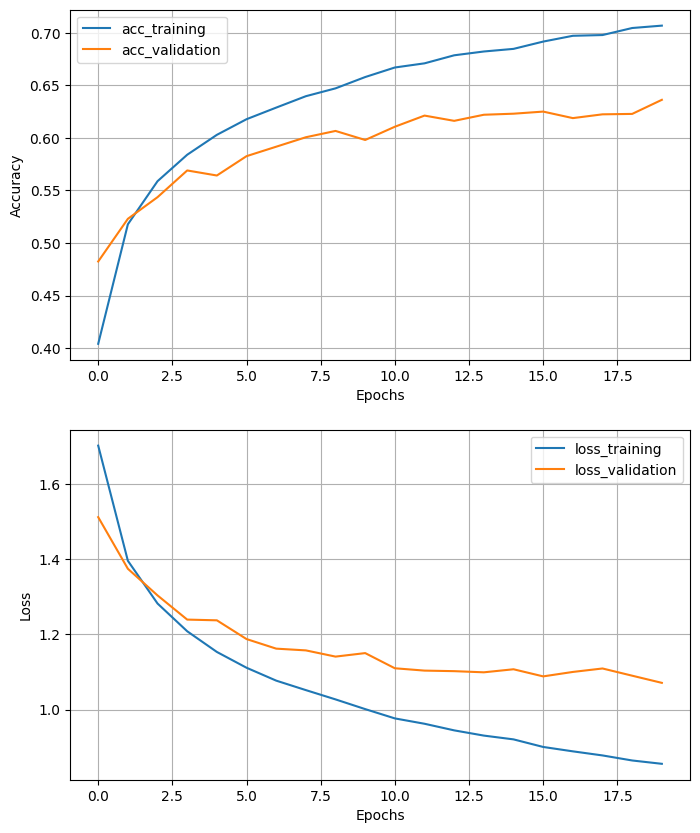

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

Finally, we test the model:

In [ ]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test / total_count_test
  loss_test = loss / n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [ ]:
test(model)

Test Loss: 1.05106127 ---------- Test Accuracy: 63.8200%


Here we see that the test accuracy of our simple CNN is about 64%.

## Visualize filters
Let's now visualize the filters emerged in the first convolutional layer.

In [ ]:
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


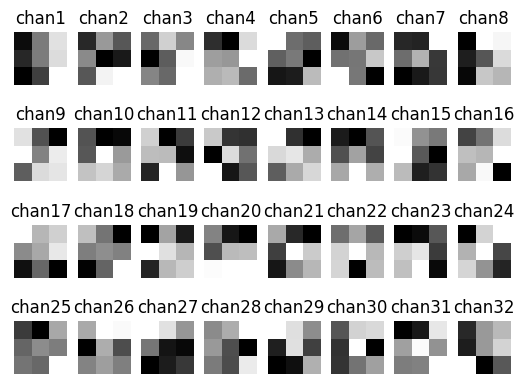

In [ ]:
conv_w0 = conv_weights[:, 0, :, :] # pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n = r*8 + c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n, :, :].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect various corners and edges.

## Parameters of a CNN [TO COMPLETE]

Explain in the cell below:

1. How are the number of parameters for Conv2D layer determined? Perform the calculations to calculate the parameters of the Conv2D layer.

`%STARTEXT`

**Answer**:

The number of parameters on a convolutional layer depend on the kernel size and the amount of filters in input and output. A simple formula to compute the number of parameters could be the following:

$$ parameters = output\_channels \cdot (input\_channels \cdot kernel\_weight \cdot kernel\_height + 1) $$
  
where $1$ is referred the bias.

In this case, we have a kernel of $3 \times 3$, so the number of parameters is equal to $32 \cdot (3 \cdot 3 \cdot 3 + 1) = 896$.

`%ENDTEXT`

# Exercise 3.2: Deep CNN


Let's consider a deeper model, more precisly in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the _softmax_ activation function


In [ ]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         2,064
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 13,210
Trainable params: 13,210
Non-trainable params: 0
Total mult-adds (M): 372.77
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.05
Estimated Total S

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 34.70%, Loss: 1.84373701 ---------------- Val_Acc: 41.68%, Val_Loss: 1.64515400
epoch: 2 -> Accuracy: 45.45%, Loss: 1.54366589 ---------------- Val_Acc: 47.22%, Val_Loss: 1.48683596
epoch: 3 -> Accuracy: 49.99%, Loss: 1.41243577 ---------------- Val_Acc: 50.52%, Val_Loss: 1.40177560
epoch: 4 -> Accuracy: 52.38%, Loss: 1.34323370 ---------------- Val_Acc: 52.24%, Val_Loss: 1.34549224
epoch: 5 -> Accuracy: 54.43%, Loss: 1.29209316 ---------------- Val_Acc: 53.88%, Val_Loss: 1.30502510
epoch: 6 -> Accuracy: 55.92%, Loss: 1.25888956 ---------------- Val_Acc: 55.36%, Val_Loss: 1.28016818
epoch: 7 -> Accuracy: 56.81%, Loss: 1.23170936 ---------------- Val_Acc: 54.90%, Val_Loss: 1.26813257
epoch: 8 -> Accuracy: 57.67%, Loss: 1.20428705 ---------------- Val_Acc: 56.42%, Val_Loss: 1.23442066
epoch: 9 -> Accuracy: 58.88%, Loss: 1.17514491 ---------------- Val_Acc: 57.14%, Val_Loss: 1.21903980
epoch: 10 -> Accuracy: 59.41%, Loss: 1.16160917 ---------------- Val_Acc: 56.16%, 

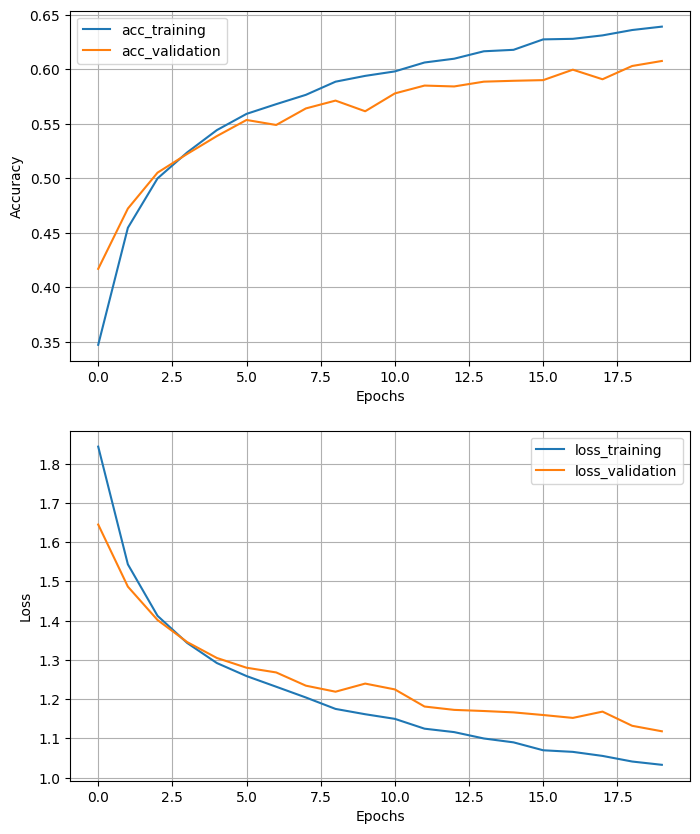

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(deep_model)

Test Loss: 1.07387650 ---------- Test Accuracy: 62.4700%


Whoa! By developing the deep CNN we dropped the accuracy fom ~64% to ~62%. It seems like we need to develop a better CNN model.

# Exercise 3.3: A better CNN [TO COMPLETE]

Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model.

**[TO COMPLETE]**: your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. At least one of the models you try should have an improvement in the test set results (generalization) over the result of the model used in the previous exercise.
In the cell below report only the code of the **best model** that you can find. In addtion, print out its result on the test set, and plot the accuracy and the loss trends in the notebook you return.
Moreover, for each setup you test, analyze and discuss the obtained results briefly in the last cells at the bottom.

Hint: each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same.
Example parameters to try to change (we suggest to test at least one re-parametrization for each of these categories):

*   number of layers or neurons or filters dimension
*   activation functions
*   epochs
*   batch sizes
*   max-pooling on/off on certain layers, or pool size

`%STARTCODE`

In [ ]:
################################
### [TO COMPLETE] START ###
# Definition of the best parameters for the CNN
conv_filters = [128, 64, 32]
kernel_sizes = [[5, 5], [3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]
### [TO COMPLETE] END ###
################################

In [ ]:
################################
### [TO COMPLETE] START ###
# Definition of the hyperparameters for CNN training
num_epochs = 50
lr = 1e-3
l2_reg = 1e-3
batch_size = 128
best_deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes, act_fs, False).to(device)
summary(best_deep_model, input_size=(batch_size, 3, 32, 32)) # summary of the best model
### [TO COMPLETE] END ###
################################

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [128, 10]                 --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-1                       [128, 128, 32, 32]        9,728
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-2                    [128, 128, 16, 16]        --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [128, 64, 16, 16]         73,792
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-4                    [128, 64, 8, 8]           --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-5                       [128, 32, 8, 8]           8,224
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-6                    [128, 3

In [ ]:
################################
### [TO COMPLETE] START ###
# Definition of the criterion and optimizer: adding L2 regularization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_deep_model.parameters(), lr=lr, weight_decay=l2_reg)
### [TO COMPLETE] END ###
################################

In [ ]:
################################
### [TO COMPLETE] START ###
# Training the best CNN model
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(best_deep_model, optimizer, dataloader_training, dataloader_validation, epochs=num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")
### [TO COMPLETE] END ###
################################

epoch: 1 -> Accuracy: 34.10%, Loss: 1.81201506 ---------------- Val_Acc: 42.98%, Val_Loss: 1.59311926
epoch: 2 -> Accuracy: 47.62%, Loss: 1.45980299 ---------------- Val_Acc: 49.46%, Val_Loss: 1.42140937
epoch: 3 -> Accuracy: 51.99%, Loss: 1.35105324 ---------------- Val_Acc: 51.94%, Val_Loss: 1.38535023
epoch: 4 -> Accuracy: 54.93%, Loss: 1.27213025 ---------------- Val_Acc: 55.76%, Val_Loss: 1.25629759
epoch: 5 -> Accuracy: 57.54%, Loss: 1.20361733 ---------------- Val_Acc: 56.20%, Val_Loss: 1.24244595
epoch: 6 -> Accuracy: 58.94%, Loss: 1.17058051 ---------------- Val_Acc: 58.02%, Val_Loss: 1.17646348
epoch: 7 -> Accuracy: 60.98%, Loss: 1.11282361 ---------------- Val_Acc: 59.78%, Val_Loss: 1.15195119
epoch: 8 -> Accuracy: 62.00%, Loss: 1.08507454 ---------------- Val_Acc: 60.78%, Val_Loss: 1.11326015
epoch: 9 -> Accuracy: 63.52%, Loss: 1.04875278 ---------------- Val_Acc: 61.10%, Val_Loss: 1.10142457
epoch: 10 -> Accuracy: 64.42%, Loss: 1.02294385 ---------------- Val_Acc: 61.58%, 

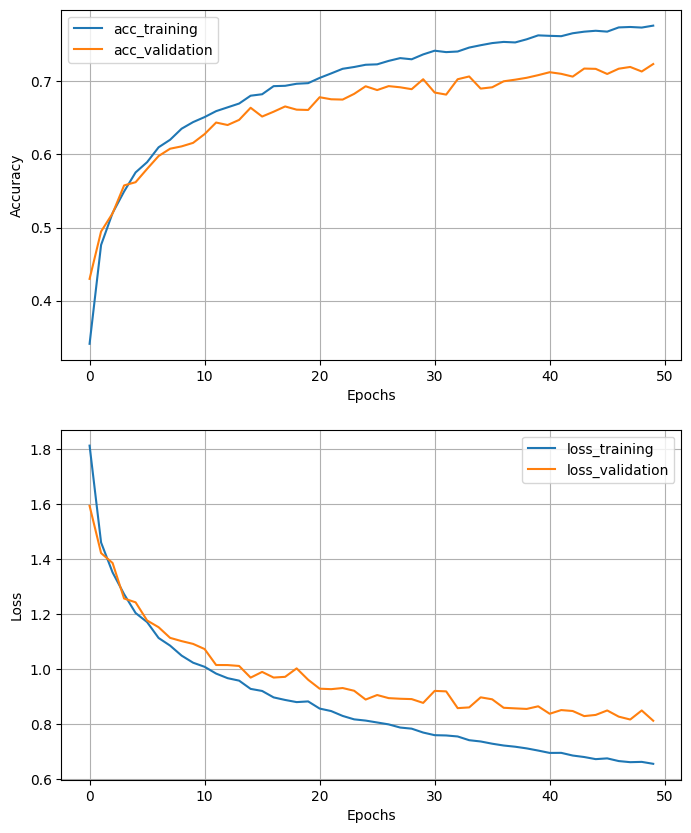

In [ ]:
################################
### [TO COMPLETE] START ###
# Plot the results obtained
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)
### [TO COMPLETE] END ###
################################

In [ ]:
################################
### [TO COMPLETE] START ###
# Test the best CNN model
test(best_deep_model)
### [TO COMPLETE] END ###
################################

Test Loss: 0.80617380 ---------- Test Accuracy: 72.7000%


`%ENDCODE`

# [TO COMPLETE] Discuss your results

In the discussion, you need to clearly motivate your choice of hyperparameters, what work and what did not work.
You also need to plot all the results of experiments you have conducted.

`%STARTEXT`

The best model that I found has the following configuration:

  * Conv2D layer with: 128 filters, $5 \times 5$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 64 filters, $3 \times 3$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 32 filters, $2 \times 2$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * Epochs: 50
  * Batch size: 128
  * L2 regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$

The achieved performance on the test set is:
  * Test loss: 0.8062
  * Test accuracy: 72.70%

Discussion:

After conducting several experimentations with various combinations of parameters, it has been observed that an increase in the number of **Conv2D** layers and **filters** enhances the accuracy of the CNN. However, to avoid overfitting, **L2** regularization is incorporated into the *Adam* optimizer. Since the model has become more complex compared to the original one, a prolonged training time of **50** epochs is justified, which results in achieving the best accuracy level.

Besides, I tested also other models:

* Model **1** (**SGD** instead of Adam):
  * Conv2D layer with: 32 filters, $3 \times 3$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 16 filters, $2 \times 2$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * **Optimizer**: *SGD*
  * Epochs: 10
  * Batch size: 128
  
  **Results** on test set:
  * Test loss: 2.2651
  * Test accuracy: 18.37%

* Model **2** (**L2** regularization):
  * Conv2D layer with: 32 filters, $3 \times 3$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 16 filters, $2 \times 2$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * Epochs: 10
  * Batch size: 128
  * **L2** regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$
  
  **Results** on test set:
  * Test loss: 1.2026
  * Test accuracy: 57.51%

* Model **3** (smaller **batch_size**):
  * Conv2D layer with: 32 filters, $3 \times 3$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 16 filters, $2 \times 2$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * Epochs: 10
  * **Batch** size: 32
  * L2 regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$

  **Results** on test set:
  * Test loss: 1.1917
  * Test accuracy: 58.04%

* Model **4** (**tanh** in Conv2D layers):
  * Conv2D layer with: 32 filters, $3 \times 3$ kernel, activation *tanh*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 16 filters, $2 \times 2$ kernel, activation *tanh*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * Epochs: 10
  * Batch size: 128
  * L2 regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$

  **Results** on test set:
  * Test loss: 1.1385
  * Test accuracy: 59.90%

* Model **5** (larger **pool_size**):
  * Conv2D layer with: 32 filters, $3 \times 3$ kernel, activation *ReLU*
  * MaxPool2D layer with: **pool_size** of $3 \times 3$
  * Conv2D layer with: 16 filters, $2 \times 2$ kernel, activation *ReLU*
  * MaxPool2D layer with: **pool_size** of $3 \times 3$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * Epochs: 10
  * Batch size: 128
  * L2 regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$

  **Results** on test set:
  * Test loss: 1.3400
  * Test accuracy: 52.65%

* Model **6** (more **filters**):
  * Conv2D layer with: **128** filters, $3 \times 3$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: **64** filters, $2 \times 2$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * Epochs: 10
  * Batch size: 128
  * L2 regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$

  **Results** on test set:
  * Test loss: 0.9824
  * Test accuracy: 66.13%

* Model **7** (larger **kernel_size**):
  * Conv2D layer with: 128 filters, $5 \times 5$ **kernel**, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 64 filters, $3 \times 3$ **kernel**, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * Epochs: 10
  * Batch size: 128
  * L2 regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$

  **Results** on test set:
  * Test loss: 0.9818
  * Test accuracy: 66.41%

* Model **8** (adding a **Conv2D** layer):
  * Conv2D layer with: 128 filters, $5 \times 5$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Conv2D layer with: 64 filters, $3 \times 3$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * **Conv2D** layer with: **32** filters, $2 \times 2$ kernel, activation *ReLU*
  * MaxPool2D layer with: pool_size of $2 \times 2$
  * Flatten
  * Dense layer with: 10 neurons, activation *softmax*
  * Optimizer: *Adam*
  * **Epochs**: 20
  * Batch size: 128
  * L2 regularization: $\lambda_{reg} = 1.0 \times 10^{-3}$

  **Results** on test set:
  * Test loss: 0.9301
  * Test accuracy: 67.85%

Discussion:

* Model **1**: using *SGD* instead of *Adam* in this model seems to lead to worse results, thus *Adam* is more suitable for this project;

* Model **2**: in regularizing the model we get a sensible augmentation of the performances with respect to the previous model. As a consequence, the regularization term should be considered in order to get a CNN model which performs better than the others;

* Model **3**: a smaller batch size improve the accuracy since the model learn from more examples in each epoch. However, with small batch sizes, there are fewer examples being processed in parallel and that can lead to slower training times, in particular for complex models. As a trade-off, we could set the $batch\_size = 128$;

* Model **4**: *tanh* in the convolutional layers produces slighlty better results in term of accuracy and loss. However, it's better to use *ReLU* with respect to *tanh* in order to avoid vanishing and exploding gradients;

* Model **5**: increasing the size in MaxPool layers does not improve the results, probably because we lose too much information from the images;

* Model **6**: using a larger number of filters in both the convolutional layers the model improves the results and the accuracy is fairly high than the previous cases since it produces more information about the input images;

* Model **7**: changing the size of the kernels in the Conv2D layers seems to improve the learning process. In fact, larger kernel sizes may help to reduce overfitting by providing a form of regularization. This is because larger kernels effectively smooth the input signal, reducing the risk of the network fitting to noise or small details in the input data;

* Model **8**: defining a more complex model we need also more epochs to train it, as specified. Adding more convolutional layers can help the model learn hierarchical representations of the data, leading to better performances.







`%ENDTEXT`

# Transfer Learning with ResNet18 + ImageNet

Let's now experiment with transfer learning. We will now load the model structure and weights of a small [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) (which is still pretty big!), pretrained on the ImageNet dataset. We will then add a fully connected layer at the end of the network and fine-tune it on the CIFAR10 dataset. In this way, we can leverage the knowledge already present in the pre-trained weight and transfer it on our task!

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
RESNET18 = resnet18(pretrained=True)
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 1000]               --
├─Conv2d: 1-1                            [128, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 16, 16]         128
├─ReLU: 1-3                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [128, 64, 8, 8]           --
├─Sequential: 1-5                        [128, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [128, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [128, 64, 8, 8]           --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. We will re-define it and make it map the features learned in the previous layer to the 10 classes of the CIFAR10 datset.

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [ ]:
# Replace the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


Finally, we "freeze" the other weights in the network so that only the ones in the last layer are trainable.

In [ ]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [ ]:
RESNET18 = RESNET18.to(device) # let's now load it to GPU

Let's consider a smaller subset of CIFAR10 in order to speed-up the fine-tuning process:

In [ ]:
train_idxs = list(range(0, len(train_data), 5))  # 45000/5=9000 Tr
val_idxs = list(range(1, len(val_data), 5))  # 5000/5=1000 Val
test_idxs = list(range(1, len(test_data), 5))  # 10000/5=2000 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In order to apply custom preprocessing steps that are expected by the pretrained model, we will define a small wrapper around the CIFAR10 dataset.

In [ ]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [ ]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size = 256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [ ]:
num_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training,
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 36.49%, Loss: 1.88327372 ---------------- Val_Acc: 57.00%, Val_Loss: 1.45028615
epoch: 2 -> Accuracy: 65.26%, Loss: 1.21104634 ---------------- Val_Acc: 66.90%, Val_Loss: 1.10304797
epoch: 3 -> Accuracy: 71.32%, Loss: 0.98014259 ---------------- Val_Acc: 69.90%, Val_Loss: 0.97232342
epoch: 4 -> Accuracy: 72.98%, Loss: 0.88705158 ---------------- Val_Acc: 70.20%, Val_Loss: 0.89333725
epoch: 5 -> Accuracy: 74.44%, Loss: 0.82297128 ---------------- Val_Acc: 70.30%, Val_Loss: 0.85995483
epoch: 6 -> Accuracy: 75.27%, Loss: 0.76691258 ---------------- Val_Acc: 71.40%, Val_Loss: 0.82378185
epoch: 7 -> Accuracy: 76.19%, Loss: 0.73302376 ---------------- Val_Acc: 71.60%, Val_Loss: 0.80555248
epoch: 8 -> Accuracy: 76.78%, Loss: 0.70919371 ---------------- Val_Acc: 71.90%, Val_Loss: 0.78296530
epoch: 9 -> Accuracy: 77.76%, Loss: 0.68450928 ---------------- Val_Acc: 71.20%, Val_Loss: 0.76817578
epoch: 10 -> Accuracy: 77.92%, Loss: 0.67121667 ---------------- Val_Acc: 72.80%, 

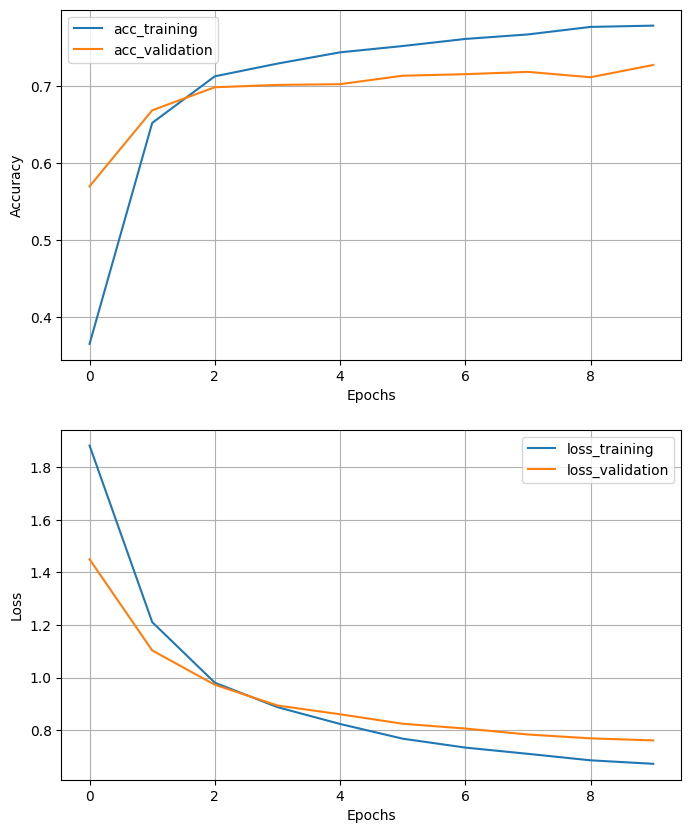

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 0.76298070 ---------- Test Accuracy: 73.5500%


Notice how we got this result by leveraging a model freely available on the internet and trained on another dataset. That's the power of transfer learning!